In [1]:
import gc
import sys
from time import time

import kernelforge
import matplotlib.pyplot as plt
import numpy as np
import rdkit
import scipy
from kernelforge import (
    _kernels,
    inverse_distance_upper,
    inverse_distance_upper_and_jacobian,
    kernel_asymm,
    kernel_symm,
)
from kernelforge._kernels import rbf_hessian_full_tiled_gemm, solve_cholesky
from rdkit import Chem
from rdkit.Chem import rdFMCS, rdmolops
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

In [2]:
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")


In [3]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
y = train["E"].flatten()
offset = y.mean()
y -= offset

In [4]:
perms_S3 = [
(0, 1, 2, 3, 4, 5, 6, 7, 8),
(0, 1, 2, 3, 4, 5, 7, 6, 8),
(0, 1, 2, 3, 4, 6, 5, 7, 8),
(0, 1, 2, 3, 4, 6, 7, 5, 8),
(0, 1, 2, 3, 4, 7, 5, 6, 8),
(0, 1, 2, 3, 4, 7, 6, 5, 8),
(0, 1, 2, 4, 3, 5, 6, 7, 8),
(0, 1, 2, 4, 3, 5, 7, 6, 8),
(0, 1, 2, 4, 3, 6, 5, 7, 8),
(0, 1, 2, 4, 3, 6, 7, 5, 8),
(0, 1, 2, 4, 3, 7, 5, 6, 8),
(0, 1, 2, 4, 3, 7, 6, 5, 8),
]
perms_S3 = np.asarray(perms_S3)
perms_S3

array([[0, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 7, 6, 8],
       [0, 1, 2, 3, 4, 6, 5, 7, 8],
       [0, 1, 2, 3, 4, 6, 7, 5, 8],
       [0, 1, 2, 3, 4, 7, 5, 6, 8],
       [0, 1, 2, 3, 4, 7, 6, 5, 8],
       [0, 1, 2, 4, 3, 5, 6, 7, 8],
       [0, 1, 2, 4, 3, 5, 7, 6, 8],
       [0, 1, 2, 4, 3, 6, 5, 7, 8],
       [0, 1, 2, 4, 3, 6, 7, 5, 8],
       [0, 1, 2, 4, 3, 7, 5, 6, 8],
       [0, 1, 2, 4, 3, 7, 6, 5, 8]])

In [5]:
def build_tril_perms_lin(tril_perms):
    """
    tril_perms: (P,D)
    returns: tril_perms_lin (P*D,) suitable for np.tile(...)[tril_perms_lin]
    """
    P, D = tril_perms.shape
    perm_offsets = np.arange(P)[:, None] * D
    tril_perms_lin = (tril_perms + perm_offsets).ravel(order="F")
    return tril_perms_lin

In [6]:
def build_tril_perms(perms):
    """
    perms: (P,N) atom permutations
    returns: tril_perms (P,D) index permutations in lower-tri order
    """
    perms = np.asarray(perms, int)
    P, N = perms.shape
    i, j = np.tril_indices(N, k=-1)
    pairs = np.stack((i, j), axis=1)
    pair_to_idx = {tuple(p): k for k,p in enumerate(pairs)}

    D = pairs.shape[0]
    tril_perms = np.empty((P, D), int)
    for pidx, perm in enumerate(perms):
        for k, (a, b) in enumerate(pairs):
            aa, bb = perm[a], perm[b]
            if aa > bb:
                key = (aa, bb)
            else:
                key = (bb, aa)
            tril_perms[pidx, k] = pair_to_idx[key]
    return tril_perms


In [7]:
def descriptor_packed_jacobian(R):
    """
    R: (N,3) coordinates
    Returns:
      phi: (D,) inverse distances (i>j, lower-tri order)
      r_d_desc: (D,3) packed Jacobian components
      pairs: (D,2) index pairs (i>j)
    """
    R = np.asarray(R, float)
    N = R.shape[0]

    # lower-triangular atom pairs
    i, j = np.tril_indices(N, k=-1)
    pairs = np.stack((i, j), axis=1)     # (D,2)
    D = pairs.shape[0]

    # pair differences and distances
    pdiff = R[i] - R[j]                  # (D,3)
    r = np.linalg.norm(pdiff, axis=1)    # (D,)
    if np.any(r == 0.0):
        raise ValueError("Zero interatomic distance encountered.")

    # descriptor and packed Jacobian
    phi = 1.0 / r                        # (D,)
    r_d_desc = pdiff / (r**3)[:, None]   # (D,3)

    return phi, r_d_desc, pairs

In [8]:
def expand_full_jacobian(r_d_desc, pairs, N):
    """Expand packed (D,3) to full (D,3N)."""
    D = r_d_desc.shape[0]
    J = np.zeros((D, 3*N), dtype=r_d_desc.dtype)
    for k,(i,j) in enumerate(pairs):
        g = r_d_desc[k]
        J[k, 3*i:3*i+3] -= g
        J[k, 3*j:3*j+3] += g
    return J

In [9]:
import numpy as np

# --------- helpers on packed (D,3) + pairs (D,2) ---------

def JT_v_packed(r_d_desc, pairs, v, N):
    """
    Compute J^T @ v using packed rows:
      r_d_desc[k] = g_k (3,), pairs[k]=(i>j)
      full row k has [-g_k at atom i, +g_k at atom j], others 0.
    """
    v = np.asarray(v, float)
    out = np.zeros(3*N, dtype=float)
    for k, (i, j) in enumerate(pairs):
        g = r_d_desc[k]              # (3,)
        w = v[k]
        out[3*i:3*i+3] -= w * g
        out[3*j:3*j+3] += w * g
    return out  # (3N,)

def accum_row_outer(H, ai, bi, aj, bj, gi, gj, coeff):
    """
    Add coeff * outer(row_i, row_j) into H, where:
      row_i has -gi at atom ai, +gi at atom bi; row_j has -gj at aj, +gj at bj.
    gi, gj are (3,) packed components; each outer is 3x3.
    """
    GiGj = np.outer(gi, gj) * coeff  # (3,3)

    # block (ai, aj): (-gi) ⊗ (-gj) = +GiGj
    H[3*ai:3*ai+3, 3*aj:3*aj+3] +=  GiGj
    # block (ai, bj): (-gi) ⊗ (+gj) = -GiGj
    H[3*ai:3*ai+3, 3*bj:3*bj+3] += -GiGj
    # block (bi, aj): (+gi) ⊗ (-gj) = -GiGj
    H[3*bi:3*bi+3, 3*aj:3*aj+3] += -GiGj
    # block (bi, bj): (+gi) ⊗ (+gj) = +GiGj
    H[3*bi:3*bi+3, 3*bj:3*bj+3] +=  GiGj

# --------- single block: Matérn-5/2 using packed inputs ---------

def matern52_block_packed(phi_i, rdi, phi_j, rdj, pairs, tril_perms, sigma, perm_norm="mean"):
    """
    Matérn-5/2 Hessian block H_ij (3N x 3N) using packed (D,3) Jacobians.

    phi_i, phi_j : (D,)
    rdi, rdj     : (D,3)   packed rows g_k for samples i and j (lower-tri order)
    pairs        : (D,2)   atom index pairs (i>j) matching the row order
    tril_perms   : (P,D)   descriptor row permutations derived from atom perms
    sigma        : float
    perm_norm    : "mean" or "sum"  (match your training convention)
    """
    D = phi_i.size
    N = int(np.max(pairs) + 1)
    P = tril_perms.shape[0]
    norm = (1.0 / P) if perm_norm == "mean" else 1.0

    H = np.zeros((3*N, 3*N), dtype=float)
    sqrt5 = np.sqrt(5.0)

    # Precompute once for i-side (used in term A): for each perm we need J_i^T @ (a_p * d_p)
    # We'll compute it per-permutation because weights depend on d_p.
    for p in range(P):
        idx = tril_perms[p]             # (D,)
        # Permute j-side descriptor and packed rows
        phi_jp  = phi_j[idx]            # (D,)
        rdj_p   = rdj[idx]              # (D,3)
        pairs_p = pairs[idx]            # (D,2) row-wise pair mapping for permuted rows

        # Descriptor diff and Matérn weights
        d = phi_i - phi_jp              # (D,)
        r = np.linalg.norm(d)           # scalar ||d||
        if r == 0.0:
            # In that rare case, e^{-rho}=1, rho=0: a=25/(3σ^4), b=5/(3σ^2)
            e = 1.0
            rho = 0.0
        else:
            rho = sqrt5 * r / sigma
            e   = np.exp(-rho)

        a = (25.0 / (3.0 * sigma**4)) * e
        b = ( 5.0 / (3.0 * sigma**2)) * (1.0 + rho) * e

        # ---- term A: J_i^T [ a * ( d ⊗ (J_j^T d) )_rowwise ] = outer( a*J_i^T d , J_j^T d )
        # Compute descriptor->Cartesian projections using packed:
        delta_cart = JT_v_packed(rdj_p, pairs_p, d, N)        # = (J_j^T @ d)
        s_i_cart   = JT_v_packed(rdi,   pairs,   a*d, N)      # = a * (J_i^T @ d)

        H += norm * np.outer(s_i_cart, delta_cart)

        # ---- term B: - b * sum_k outer(J_i_row_k, J_j_row_k^(p))
        # Accumulate row-by-row using sparsity (two atoms per row).
        coeff = - norm * b
        for k in range(D):
            ai, bi = pairs[k]
            aj, bj = pairs_p[k]
            gi = rdi[k]      # (3,)
            gj = rdj_p[k]    # (3,)
            accum_row_outer(H, ai, bi, aj, bj, gi, gj, coeff)

    return H

# --------- full training kernel (symmetric) with packed inputs ---------

def assemble_training_kernel_matern52_packed(PHI, RD, pairs, tril_perms, sigma, perm_norm="sum"):
    """
    Build full symmetric training kernel K using packed Jacobians.

    PHI   : (M, D)      descriptors for all M training samples
    RD    : (M, D, 3)   packed jacobians for all samples (same row order as PHI)
    pairs : (D, 2)      lower-tri pairs used for all samples (same topology)
    tril_perms : (P, D) descriptor row permutations
    sigma : float
    perm_norm : "mean" or "sum"
    """
    M, D = PHI.shape
    N = int(np.max(pairs) + 1)
    dim = 3 * N

    K = np.zeros((M*dim, M*dim), dtype=float)
    for j in tqdm(range(M)):
        for i in range(j, M):
            Hij = matern52_block_packed(PHI[i], RD[i], PHI[j], RD[j], pairs, tril_perms, sigma, perm_norm)
            i0, i1 = i*dim, (i+1)*dim
            j0, j1 = j*dim, (j+1)*dim
            K[i0:i1, j0:j1] = Hij
            if i != j:
                K[j0:j1, i0:i1] = Hij.T
    return K


In [10]:
X = np.asarray([descriptor_packed_jacobian(r)[0] for r in train["R"]])
dX = np.asarray([descriptor_packed_jacobian(r)[1] for r in train["R"]])
pairs = descriptor_packed_jacobian(train["R"][0])[2]

In [11]:
Xp = np.asarray([descriptor_packed_jacobian(r)[0] for r in test["R"]])
dXp = np.asarray([descriptor_packed_jacobian(r)[1] for r in test["R"]])

In [12]:
tril_perms = build_tril_perms(perms_S3)
tril_perms_lin = build_tril_perms_lin(tril_perms)

In [211]:
np.set_printoptions(threshold=np.inf, linewidth=999)
sigma_matern = 10.0
n_train = 200
K = assemble_training_kernel_matern52_packed(X[:n_train], dX[:n_train], pairs, tril_perms, sigma_matern)
K[:27, :27]

  0%|          | 0/200 [00:00<?, ?it/s]

array([[-7.95858947e-02, -5.23904752e-03,  1.25270362e-03,  2.59059248e-02,  1.74214242e-02,  5.95743448e-04,  3.00407736e-02, -2.49537202e-02,  1.36127951e-03,  1.95560960e-04,  2.36406283e-03, -2.87522752e-03,  1.98776787e-06,  2.17574400e-03,  3.01793785e-03,  5.72619033e-03,  1.03473656e-03,  1.47438354e-04,  3.21470902e-03,  5.77343805e-03,  2.73983906e-03,  4.34505810e-03,  4.83991616e-03, -3.34797582e-03,  1.01556901e-02, -3.41655412e-03, -2.89173850e-03],
       [-5.23904752e-03, -1.48166413e-01, -3.13721629e-03,  1.74202793e-02,  1.17191281e-02,  4.02507366e-04, -2.49542765e-02,  2.07281446e-02, -1.13081337e-03,  4.49795897e-03,  5.43376442e-02, -6.60891906e-02,  4.16209758e-05,  5.00200212e-02,  6.93871727e-02,  5.01849239e-03,  9.05844269e-04,  1.29923073e-04,  2.82170802e-03,  5.06168855e-03,  2.40146459e-03,  3.81006982e-03,  4.24457632e-03, -2.93654155e-03, -3.41680547e-03,  1.14936591e-03,  9.72694075e-04],
       [ 1.25270362e-03, -3.13721629e-03, -1.04187656e-03,  5.95

In [212]:
K_solve = -K.copy()
yf = -train["F"][:n_train].flatten()
y_std = np.std(yf)
yf /= y_std
# print(yf)
K_solve[np.diag_indices_from(K_solve)] += 1e-10
# Cholesky (do not overwrite K in case we need to retry)
L, lower = scipy.linalg.cho_factor(
    K_solve, overwrite_a=False, check_finite=False
)
alphas = -scipy.linalg.cho_solve(
    (L, lower), yf, overwrite_b=False, check_finite=False
)
print("DID CHOLESKY")
# alpha = np.linalg.solve(K_solve, yf)
alpha = solve_cholesky(K_solve, yf)
alpha[:54]

DID CHOLESKY


array([  887053.66149203,  -982645.19878232,   334491.04663856, -1154620.68151868,  -163856.50787808, -1236998.90471502,   -84749.93232213,  -886110.26699082,  -344871.40553062, -3894863.55869422,   981146.41878548,  1657742.88325783,  3760994.52302893,  1589822.72381512, -1109501.45963568, -1579124.03909631, -1805304.4539768 ,  -234989.10308907,  -958377.01750715,   -93855.48362923, -1144014.20556498,  1011794.50805131,  1821558.77216695,  -222872.76290968,  2011832.87866461,  -460761.05474008,  2301039.81267467,   373185.06547342, -1827319.10698421,  -573847.54180635,  2359598.48943182,  1354535.17051761,  -664572.30280439, -4247471.88530705,  6446787.35383825,  7813131.32777728,   875671.8397279 , -5019075.49156165, -5028220.58482769, -3040589.91013316,   -35296.20643036, -1421466.29216323,  5344861.36654864, -1415394.56876582,  4858209.98850622,  1126707.1014065 ,  5390908.93213011, -6425815.99976636, -4067375.38259386, -2207774.14467773,  -663294.4398243 ,  1275522.72289712,
     

In [213]:
np.asarray([-19524.290653052165, 13149.88994697071, -5382.020034720166, 12287.058462689194, -6159.448928517929, -15975.021012450356, 11360.322175228057, 104518.88544569373, 403969.5309743163, 78721.00313549452, -314639.45589901006, -286865.23648502136, -113013.71197489995, 363140.3460643816, -273979.55471952975, -47158.8061418849, -130566.685900902, 671048.4399614931, -239353.16131145362, 456743.3409697777, -623433.984600948, 278444.6246340134, -296194.48102423904, -164323.3223078711, 38185.5537149039, -189992.59631467413, 294889.71972672996, -32945.36838358819, -82579.58238882862, -285363.3672296998, -68758.1066909802, -114304.62584299693, -182516.238817309, -89421.03663112372, -60414.23268010538, 906072.7597798583, -287445.2603039505, -600091.4152337778, -645252.8807484577, 239328.59918895294, 528236.8305435141, -785498.2556763021, 412629.8588653789, 444600.0077967052, 1683417.865716988, 738901.1967697173, 863211.3782825317, -1609875.0816045767, -1190153.4792601939, -1380267.1812738567, -245384.80056353196, 277967.4357408354, 401556.39909181773, 1164400.582263253])


array([  -19524.29065305,    13149.88994697,    -5382.02003472,    12287.05846269,    -6159.44892852,   -15975.02101245,    11360.32217523,   104518.88544569,   403969.53097432,    78721.00313549,  -314639.45589901,  -286865.23648502,  -113013.7119749 ,   363140.34606438,  -273979.55471953,   -47158.80614188,  -130566.6859009 ,   671048.43996149,  -239353.16131145,   456743.34096978,  -623433.98460095,   278444.62463401,  -296194.48102424,  -164323.32230787,    38185.5537149 ,  -189992.59631467,   294889.71972673,   -32945.36838359,   -82579.58238883,  -285363.3672297 ,   -68758.10669098,  -114304.625843  ,  -182516.23881731,   -89421.03663112,   -60414.23268011,   906072.75977986,  -287445.26030395,  -600091.41523378,  -645252.88074846,   239328.59918895,   528236.83054351,  -785498.2556763 ,   412629.85886538,   444600.00779671,  1683417.86571699,   738901.19676972,   863211.37828253, -1609875.08160458, -1190153.47926019, -1380267.18127386,  -245384.80056353,   277967.43574084,
     

In [214]:
def pack_alphas(PHI, RD, pairs, alphas):
    """
    Contract alphas (Cartesian) into descriptor space.
    
    Parameters
    ----------
    PHI    : (M,D) descriptor array (not used, just to get sizes)
    RD     : (M,D,3) packed Jacobians for each sample
    pairs  : (D,2) atom index pairs
    alphas : (M*3N,) regression weights in Cartesian space
    
    Returns
    -------
    RD_ALPHA : (M,D) each row is J_m @ alpha_m
    """
    M, D, _ = RD.shape
    N = int(np.max(pairs) + 1)
    dim = 3 * N
    alphas = alphas.reshape(M, dim)

    RD_ALPHA = np.zeros((M, D))
    for m in range(M):
        v = np.zeros(D)
        for k, (i, j) in enumerate(pairs):
            g = RD[m, k]        # (3,)
            # contribution from atoms i,j
            v[k] = (-g @ alphas[m, 3*i:3*i+3]) + (g @ alphas[m, 3*j:3*j+3])
        RD_ALPHA[m] = v
    return RD_ALPHA

In [215]:
import numpy as np

# --- packed projection: J^T @ v (v in descriptor space) ---
def JT_v_packed(r_d_desc, pairs, v, N):
    out = np.zeros(3*N, dtype=float)
    for k,(i,j) in enumerate(pairs):
        g = r_d_desc[k]  # (3,)
        w = v[k]
        out[3*i:3*i+3] -= w * g
        out[3*j:3*j+3] += w * g
    return out

def predict_matern52_packed_simple(
    phi_q, rd_q, pairs,              # query: (D,), (D,3), (D,2)
    PHI, RD_ALPHA,                   # training banks: (M,D), (M,D) with RD_ALPHA[m] = J_m @ alpha_m
    tril_perms,                      # (P,D) descriptor row permutations (from atom perms)
    sigma, std=1.0, c=0.0,           # model scale & energy offset
    return_energy=True
):
    """
    Returns (E, F) or (F,) for the query geometry.
    Mirrors sGDML _predict_wkr algebra (Matérn-5/2), but in a small function.
    """
    phi_q   = np.asarray(phi_q,   float)   # (D,)
    rd_q    = np.asarray(rd_q,    float)   # (D,3)
    PHI     = np.asarray(PHI,     float)   # (M,D)
    RD_ALPHA= np.asarray(RD_ALPHA,float)   # (M,D)
    tril    = np.asarray(tril_perms, int)  # (P,D)

    D = phi_q.size
    N = int(np.max(pairs) + 1)
    sqrt5 = np.sqrt(5.0)

    # descriptor-space accumulator and energy (pre-scale, like _predict_wkr)
    F_desc = np.zeros(D, dtype=float)
    E_pred = 0.0

    sig_inv = 1.0 / sigma
    mat52_base_fact = 5.0 / (3.0 * sigma**3)   # exactly as in the official code
    diag_scale_fact = 5.0 / sigma

    for j in range(PHI.shape[0]):
        # Permute training sample j across all P perms (vectorized)
        phi_j_perm  = PHI[j][tril]        # (P,D)
        rda_j_perm  = RD_ALPHA[j][tril]   # (P,D) == (J_j^(p) @ alpha_j)

        # Differences and norms
        diff = phi_q[None, :] - phi_j_perm                # (P,D)
        norm_ab = sqrt5 * np.linalg.norm(diff, axis=1)    # (P,)  == σ * ρ

        # mat52_base starts as exp(-ρ) * 5/(3σ^3)
        mat52_base = np.exp(-norm_ab * sig_inv) * mat52_base_fact  # (P,)

        # a_x2 = (d · (J_j^(p) α_j)) per perm
        a_x2 = np.einsum('pd,pd->p', diff, rda_j_perm)             # (P,)

        # First term: F_desc += (a_x2 * mat52_base).dot(diff) * diag_scale_fact
        F_desc += (a_x2 * mat52_base).dot(diff) * diag_scale_fact  # (D,)

        # Scale base for second term: mat52_base *= (norm_ab + sigma)
        mat52_base *= (norm_ab + sigma)                            # now = b(ρ)

        # Second term: F_desc -= mat52_base.dot(rda_j_perm)
        F_desc -= mat52_base.dot(rda_j_perm)                       # (D,)

        # Energy accumulates with the same (scaled) base:
        E_pred += a_x2.dot(mat52_base)

    # Project to Cartesian: F = J_q^T @ F_desc  (packed)
    F = JT_v_packed(rd_q, pairs, F_desc, N)

    # Final scaling & energy offset, exactly like sGDML
    F *= std
    E = E_pred * std + c
    return E, F

In [231]:
pd_alphas = pack_alphas(X[:n_train], dX[:n_train], pairs, alphas)
idx_test = 1
fp = predict_matern52_packed_simple(
    Xp[idx_test], dXp[idx_test], pairs,            # query: (D,), (D,3), (D,2)
    X[:n_train], pd_alphas,                 # training: (M,D), (M,D) where RD_ALPHA[m] = (J_m @ alpha_m)
    tril_perms,                    # (P,D) descriptor row permutations
    sigma_matern,                         # scalar
    return_energy=False
)[1] * y_std
fp

array([ 46.70084102,  -4.71427145,  -7.35009637,   1.48889283,  70.87743229, -12.88632947,   9.02280103,  32.49164526,  74.86983422, -34.54393258,  10.79639648, -20.76663651,  -5.03187566, -24.35643806,  -6.49755499, -31.65767316, -28.64729116,  31.63133282,  -2.68878095, -22.06481959,   8.45487893,   5.34283925,  -2.01953351, -11.7828874 ,  11.36688823, -32.36312027, -55.67254122])

In [232]:
fp.shape

(27,)

In [233]:
ft = -test["F"][idx_test].flatten()
ft

array([ 46.91837923,  -3.73109559,  -5.94115822,   0.61561766,  72.42908142, -11.67441359,   9.22106886,  32.09283234,  75.64856807, -34.57462118,  10.50739625, -21.64424784,  -4.18701497, -26.3018366 ,  -7.9454866 , -30.84474   , -29.022508  ,  31.95702315,  -2.79564777, -22.39369865,   7.6387786 ,   5.07544835,  -2.40971674, -12.61999033,  10.57150982, -31.17045454, -55.41907336])

RMSE = 0.87 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9996010841109978), pvalue=np.float64(2.962084469601087e-40))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

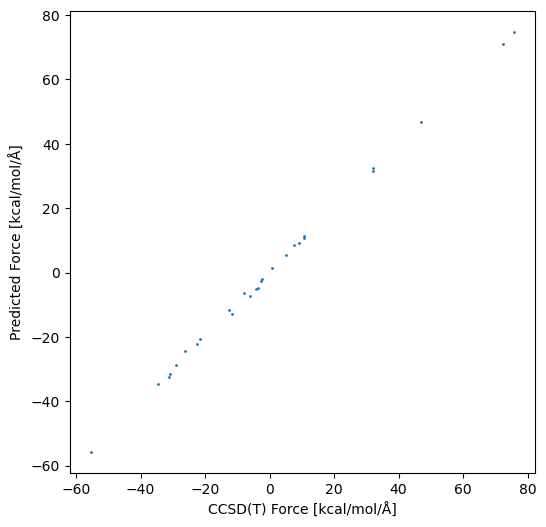

In [234]:
res = pearsonr(ft, fp)
rmse = np.sqrt(np.mean(np.square(ft - fp)))
print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
fig = plt.figure(figsize=(6,6))
plt.scatter(ft, fp, s=1)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")

In [ ]:
Xp[:1]